In [ ]:
import os
import json
import requests
from tqdm import tqdm
from collections import defaultdict, Counter
from sparc.client import SparcClient

# === Setup ===
client = SparcClient(connect=False, config_file='config.ini')

# === Step 1: Run Elasticsearch-style query to get a known ID range ===
ids = list(range(0, 1001))
id_strings = [f'"{i}"' for i in ids]
id_list_str = ", ".join(id_strings)

body = f'''
{{
  "size": 1000,
  "query": {{
    "terms": {{
      "_id": [ {id_list_str} ]
    }}
  }}
}}
'''
body_json = json.loads(body)
response = client.metadata.search_datasets(body_json)

# === Step 2: Filter and categorize by type ===
type_counter = Counter()
type_id_map = defaultdict(list)

for d in response["hits"]["hits"]:
    try:
        type_name = d["_source"]["item"]["types"][0]["name"]
    except (KeyError, IndexError, TypeError):
        type_name = "<invalid or missing type>"

    type_counter[type_name] += 1
    dataset_id = d.get("_id", "<no id>")
    type_id_map[type_name].append(dataset_id)

# === Step 3: Show summary ===
print("Dataset type counts:")
for t, count in type_counter.items():
    print(f"{t}: {count}")

print("\nProcessing only type = 'dataset'")
dataset_ids = type_id_map["dataset"]
print(f"Found {len(dataset_ids)} datasets.\n")

# === Step 4: Process only datasets and collect extensions ===
dataset_paths = []
non_dataset_count = 0
error_count = 0
extension_counter = Counter()

for dataset_id in tqdm(dataset_ids, desc="Processing datasets"):
    # === Fetch metadata ===
    metadata_url = f"https://api.pennsieve.io/discover/datasets/{dataset_id}/versions/1/metadata"
    try:
        meta_response = requests.get(metadata_url)
        meta_response.raise_for_status()
        metadata = meta_response.json()
    except Exception as e:
        tqdm.write(f"[ERROR] Metadata fetch failed for dataset {dataset_id}: {e}")
        error_count += 1
        continue

    # === Extract 'files/primary/' paths and extensions ===
    primary_paths = [
        f.get("path") for f in metadata.get("files", [])
        if f.get("path", "").startswith("files/primary/")
    ]

    if primary_paths:
        dataset_paths.append((dataset_id, primary_paths))
        for path in primary_paths:
            _, ext = os.path.splitext(path)
            ext = ext.lower() if ext else "<no extension>"
            extension_counter[ext] += 1

        tqdm.write(f"  Primary file paths for dataset {dataset_id}: {primary_paths}")
    else:
        tqdm.write(f"  No files under 'files/primary/' for dataset {dataset_id}.")
        non_dataset_count += 1

# === Final Summary ===
tqdm.write("\n=== Summary ===")
tqdm.write(f"Total datasets queried: {len(dataset_ids)}")
tqdm.write(f"Metadata errors: {error_count}")
tqdm.write(f"Datasets without primary files: {non_dataset_count}")
tqdm.write(f"Datasets with primary files: {len(dataset_paths)}")

In [ ]:
# === Extension Summary ===
tqdm.write("\nAvailable file extensions in 'files/primary/':")
for ext, count in sorted(extension_counter.items(), key=lambda x: -x[1]):
    if count >= 100:  # Only show extensions with significant counts
        tqdm.write(f"{ext}: {count}")

Category: Imaging, Datasets: 115
Category: Other, Datasets: 93
Category: Time Series, Datasets: 79
Category: Docs, Datasets: 194

Total datasets processed: 481
Dataset paths: 209


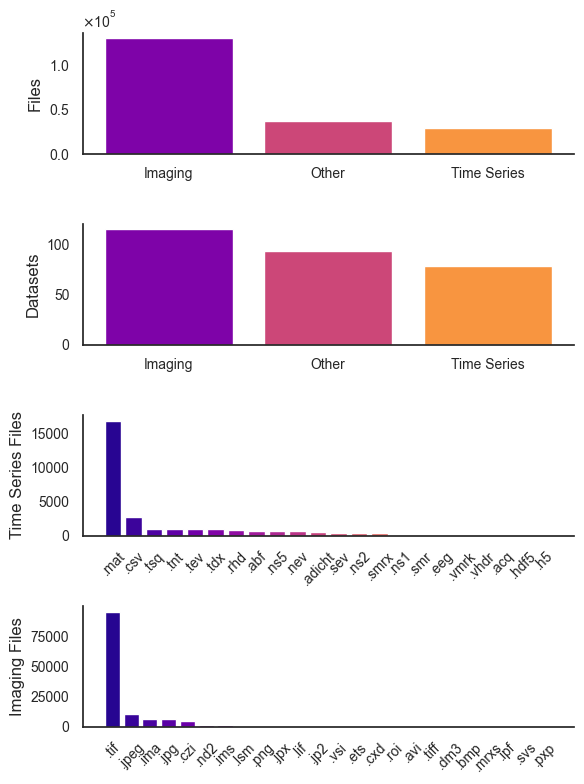

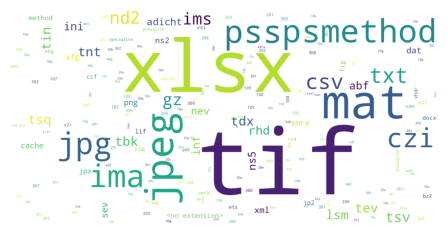


Dataset IDs per category:
=== Imaging Datasets ===
(115): 268, 73, 287, 234, 386, 205, 230, 145, 362, 240, 53, 345, 409, 373, 75, 109, 423, 293, 57, 402, 252, 336, 348, 118, 88, 256, 385, 189, 314, 419, 82, 371, 65, 265, 77, 187, 394, 399, 233, 165, 55, 260, 283, 158, 304, 215, 372, 296, 231, 390, 383, 370, 331, 97, 61, 178, 302, 366, 367, 389, 168, 238, 403, 333, 85, 332, 60, 204, 266, 137, 159, 242, 291, 274, 388, 381, 59, 162, 56, 261, 317, 132, 117, 369, 353, 226, 425, 89, 253, 321, 90, 391, 108, 337, 387, 64, 237, 175, 354, 290, 54, 216, 416, 120, 421, 209, 229, 368, 382, 221, 347, 161, 424, 225, 415

=== Time Series Datasets ===
(79): 149, 211, 287, 151, 351, 169, 177, 164, 224, 254, 130, 409, 210, 357, 142, 338, 121, 272, 378, 57, 244, 336, 88, 236, 349, 46, 400, 206, 323, 228, 316, 245, 264, 50, 51, 283, 58, 241, 407, 52, 215, 107, 297, 126, 239, 333, 143, 350, 204, 375, 291, 243, 274, 180, 257, 163, 270, 148, 425, 123, 315, 48, 253, 301, 106, 391, 108, 185, 271, 237, 150, 183

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# Use seaborn for cleaner minimal plots
sns.set_theme(style="white")

# Ensure output directory exists
output_dir = './stats_figures'
os.makedirs(output_dir, exist_ok=True)

# Map extensions to categories, merging Tabular and Structured into Docs
modality_lookup = {
    # Imaging formats
    ".tif": "Imaging", ".tiff": "Imaging", ".czi": "Imaging", ".nd2": "Imaging", ".lsm": "Imaging",
    ".jpx": "Imaging", ".svs": "Imaging", ".ims": "Imaging", ".png": "Imaging", ".jpg": "Imaging",
    ".jpeg": "Imaging", ".bmp": "Imaging", ".vsi": "Imaging", ".jp2": "Imaging", ".roi": "Imaging",
    ".dm3": "Imaging", ".pxp": "Imaging", ".ipf": "Imaging", ".lif": "Imaging", ".ima": "Imaging",
    ".mrxs": "Imaging", ".obj": "Imaging", ".avi": "Imaging", ".exf": "Imaging", ".cxd": "Imaging",
     ".ets": "Imaging",

    # Time Series formats
    ".mat": "Time Series", ".smr": "Time Series", ".csv": "Time Series",
    ".adicht": "Time Series", ".hdf5": "Time Series", ".h5": "Time Series",
    ".abf": "Time Series", ".rhd": "Time Series", ".nev": "Time Series", ".ns5": "Time Series",
    ".ns2": "Time Series", ".ns1": "Time Series", ".smrx": "Time Series", ".wav": "Time Series",
    ".acq": "Time Series", ".tdx": "Time Series", ".tev": "Time Series",
    ".tnt": "Time Series", ".tsq": "Time Series", ".eeg": "Time Series",
    ".vmrk": "Time Series", ".vhdr": "Time Series", ".sev": "Time Series", 
    #".sam": "Time Series",
    #".pss": "Time Series",
    #".tin": "Time Series", 
    #".tbk": "Time Series",


    # Documentation formats
    ".pdf": "Docs", ".docx": "Docs", ".doc": "Docs", ".txt": "Docs",
    ".xlsx": "Docs", ".xls": "Docs", ".tsv": "Docs", ".json": "Docs", 
    ".xml": "Docs", ".db": "Docs", ".xfg": "Docs",
    
    # Other formats
    ".inf": "Other", ".zip": "Other", "": "Other", "(no ext)": "Other",
    ".s2r": "Other", ".ini": "Other", ".cmgui": "Other",
    ".mp4": "Other", ".gz": "Other", ".xlsm": "Other",
    ".db3": "Other", ".ccf": "Other", ".ex": "Other",
    ".conf": "Other", ".rdf": "Other", ".vtk": "Other", ".proj": "Other", ".pnp": "Other",
    ".hoc": "Other", ".fig	": "Other", ".dat": "Other", ".psmethod": "Other"
}

# === Summary structures ===
summary = {}
modality_extension_counts = defaultdict(Counter)
dataset_category = defaultdict(set)
datasets_with_timeseries = set()

# === Process the dataset file paths ===
for dataset_id, paths in dataset_paths:
    has_ts = False
    has_img = False
    has_docs = False
    for p in paths:
        ext = os.path.splitext(p)[1].lower() or '(no ext)'
        category = modality_lookup.get(ext, 'Other')
        summary[ext] = summary.get(ext, 0) + 1
        modality_extension_counts[category][ext] += 1
        if category == 'Time Series':
            has_ts = True
        elif category == 'Imaging':
            has_img = True
        elif category == 'Documentation':
            has_docs = True
        dataset_category[category].add(dataset_id)
    if has_ts:
        datasets_with_timeseries.add(dataset_id)
    elif has_img:
        dataset_category['Imaging'].add(dataset_id)
    elif has_docs:
        dataset_category['Documentation'].add(dataset_id)
    else:
        dataset_category['Other'].add(dataset_id)


# iterate over dataset categories
tot = 0
for category, ids in dataset_category.items():
    print(f"Category: {category}, Datasets: {len(ids)}")
    tot += len(ids)

print(f"\nTotal datasets processed: {tot}")

print(f"Dataset paths: {len(dataset_paths)}")

# === Create summaries ===
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['File Count'])
summary_df.index.name = 'Extension'
summary_df['Category'] = summary_df.index.map(lambda x: modality_lookup.get(x, 'Other'))
summary_df = summary_df.sort_values('File Count', ascending=False)

category_summary = (
    summary_df[summary_df['Category'] != 'Unknown']
    .groupby('Category')['File Count']
    .sum()
    .sort_values(ascending=False)
)

dataset_series = pd.Series({cat: len(ids) for cat, ids in dataset_category.items() if cat != 'Unknown'}).sort_values(ascending=False)
ts_series = pd.Series(modality_extension_counts['Time Series']).sort_values(ascending=False)
img_series = pd.Series(modality_extension_counts['Imaging']).sort_values(ascending=False)

# === Plot configuration ===
TICK_FS = 10
LABEL_FS = 12

# For a half 16:9 slide (6 x 8 inches)
fig, axes = plt.subplots(4, 1, figsize=(6, 8))

# Y-axis label texts for each subplot
y_labels = ['Files', 'Datasets', 'Time Series Files', 'Imaging Files']
i = 0
for ax, data, ylab in zip(axes, [category_summary, dataset_series, ts_series, img_series], y_labels):
    if i<=1:
        #filter out docs
        data = data[data.index != 'Docs']
    ax.bar(data.index, data.values, color=sns.color_palette('plasma', len(data)))
    ax.tick_params(axis='x', labelsize=TICK_FS)
    ax.tick_params(axis='y', labelsize=TICK_FS)
    ax.set_ylabel(ylab, fontsize=LABEL_FS)
    # Scientific notation
    if i==0:
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    # Match offset text size
    offset = ax.yaxis.get_offset_text()
    offset.set_fontsize(TICK_FS)
    i += 1

# Rotate x-ticks for last two
for ax in axes[2:]:
    ax.tick_params(axis='x', rotation=45)

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'combined_4x1_summary_minimal_sorted.svg'), format='svg')
plt.show()


# === Word Cloud: File Extension Frequencies ===
from wordcloud import WordCloud

# Filter extension_counter to only include counts ≥ 100
wc_freq = {
    ext.lstrip('.') or 'no_ext': count
    for ext, count in extension_counter.items()
    if count >= 1
}

# Generate word cloud
graph = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(wc_freq)

# Plot word cloud
plt.figure(figsize=(5, 2.5))
plt.imshow(graph)
plt.axis('off')
plt.tight_layout()
# Save the word cloud
plt.savefig(os.path.join(output_dir, 'file_extensions_wordcloud.svg'), format='svg')
plt.show()

# print ids per category
print("\nDataset IDs per category:")
print("=== Imaging Datasets ===")
print(f"({len(dataset_category['Imaging'])}): {', '.join(map(str, dataset_category['Imaging']))}")
print("\n=== Time Series Datasets ===")
print(f"({len(dataset_category['Time Series'])}): {', '.join(map(str, dataset_category['Time Series']))}")
print("\n=== Documentation Datasets ===")
print(f"({len(dataset_category['Documentation'])}): {', '.join(map(str, dataset_category['Documentation']))}")
print("\n=== Other Datasets ===")
print(f"({len(dataset_category['Other'])}): {', '.join(map(str, dataset_category['Other']))}")

# print totla number of file formats
print(f"\nTotal number of unique file formats: {len(modality_lookup)}")

### Prepare Figures fo GitHub Readme

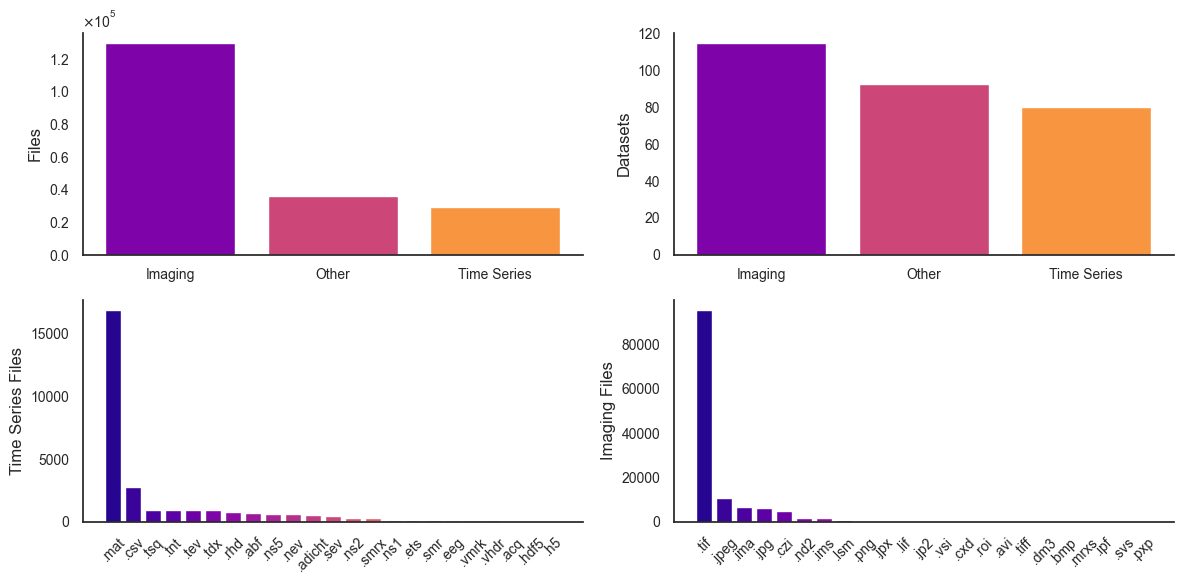

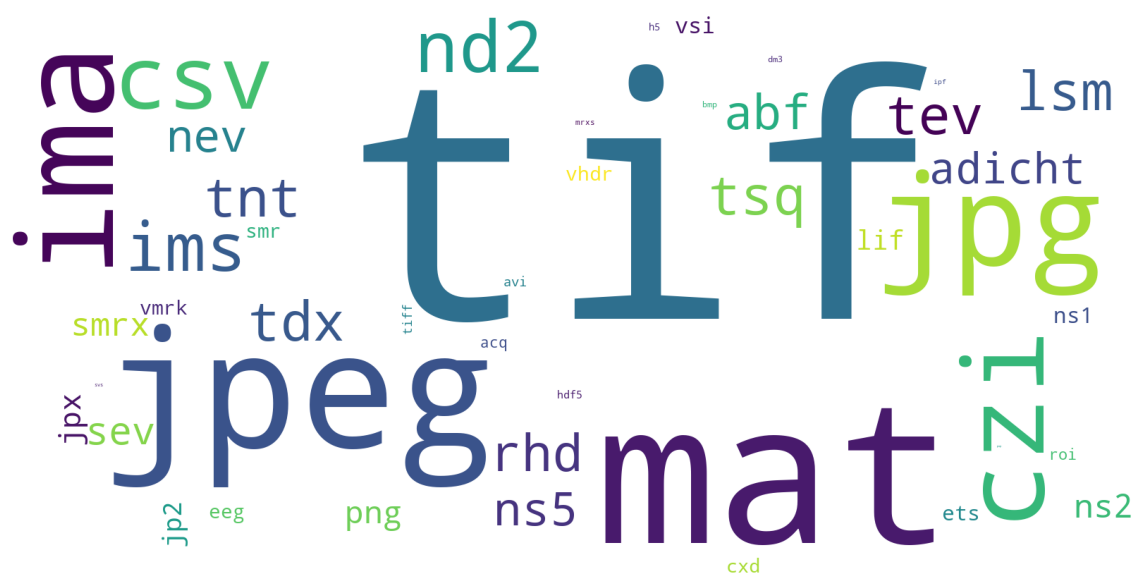


Dataset IDs per category
=== Imaging (115) ===
108, 109, 117, 118, 120, 132, 137, 145, 158, 159, 161, 162, 165, 168, 175, 178, 187, 189, 204, 205, 209, 215, 216, 221, 225, 226, 229, 230, 231, 233, 234, 237, 238, 240, 242, 252, 253, 256, 260, 261, 265, 266, 268, 274, 283, 287, 290, 291, 293, 296, 302, 304, 314, 317, 321, 331, 332, 333, 336, 337, 345, 347, 348, 353, 354, 362, 366, 367, 368, 369, 370, 371, 372, 373, 381, 382, 383, 385, 386, 387, 388, 389, 390, 391, 394, 399, 402, 403, 409, 415, 416, 419, 421, 423, 424, 425, 53, 54, 55, 56, 57, 59, 60, 61, 64, 65, 73, 75, 77, 82, 85, 88, 89, 90, 97
=== Time Series (80) ===
106, 107, 108, 120, 121, 123, 126, 130, 142, 143, 148, 149, 150, 151, 163, 164, 169, 177, 180, 183, 185, 204, 206, 210, 211, 215, 224, 228, 229, 236, 237, 239, 241, 243, 244, 245, 253, 254, 257, 258, 262, 264, 270, 271, 272, 274, 283, 287, 291, 297, 301, 315, 316, 323, 333, 336, 338, 349, 350, 351, 357, 375, 376, 378, 380, 391, 400, 407, 409, 419, 425, 46, 48, 50, 51, 5

In [11]:
TICK_FS, LABEL_FS = 10, 12
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

plots_and_labels = [
    (category_summary[category_summary.index != "Docs"], "Files"),
    (dataset_series[dataset_series.index != "Docs"], "Datasets"),
    (ts_series, "Time Series Files"),
    (img_series, "Imaging Files"),
]

for ax, (data, ylab) in zip(axes, plots_and_labels):
    ax.bar(data.index, data.values, color=sns.color_palette("plasma", len(data)))
    ax.set_ylabel(ylab, fontsize=LABEL_FS)
    ax.tick_params(axis="x", labelsize=TICK_FS)
    ax.tick_params(axis="y", labelsize=TICK_FS)
    if ylab == "Files":
        ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0), useMathText=True)
        ax.yaxis.get_offset_text().set_fontsize(TICK_FS)

for ax in axes[2:]:
    ax.tick_params(axis="x", rotation=45)

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_2x2_summary.png"), format="png")
plt.show()

# ── Word cloud of extensions ──────────────────────────────────────────────────
wc_freq = {
    ext.lstrip(".") or "no_ext": count
    for ext, count in extension_counter.items()
    if count >= 1
}

# filter out documentation and other formats using the  modality_lookup
wc_freq = {ext: count for ext, count in wc_freq.items() if modality_lookup.get(f".{ext}", "Other") not in ["Docs", "Other"]}

plt.figure(figsize=(12, 6))
WordCloud(width=1600, height=800, background_color="white")\
    .generate_from_frequencies(wc_freq)\
    .to_image()
plt.imshow(WordCloud(width=1600, height=800, background_color="white").generate_from_frequencies(wc_freq))
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "file_extensions_wordcloud.png"), format="png")
plt.show()

# ── Console summaries ────────────────────────────────────────────────────────
print("\nDataset IDs per category")
for cat in ["Imaging", "Time Series", "Docs", "Other"]:
    ids = sorted(dataset_category[cat])
    print(f"=== {cat} ({len(ids)}) ===")
    print(", ".join(map(str, ids)) or "—")

print(f"\nTotal number of unique file formats: {len(modality_lookup)}")
